In [4]:
#@title Import MuJoCo, MJX, and Brax

from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.apg import train as apg
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

In [5]:

import distutils.util
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [6]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


gpu


In [7]:
with open('models/humanoidMjx.xml', 'r') as file:
    xml = file.read()


mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
#renderer = mujoco.Renderer(mj_model, height=480, width=640)

In [8]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0.    0.    1.282 1.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ] <class 'numpy.ndarray'>
[0.    0.    1.282 1.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ] <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=0)}


In [9]:
#@title Humanoid Env

class Humanoid(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = 'models/humanoidMjx.xml'
    mj_model = mujoco.MjModel.from_xml_path(path)
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

In [10]:
# instantiate the environment
env_name = 'humanoid'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


In [11]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(19):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

#media.show_video(env.render(rollout, camera='side'), fps=1.0 / env.dt)

In [10]:
#HTML(html.render(env.sys.replace(dt=env.dt), rollout))

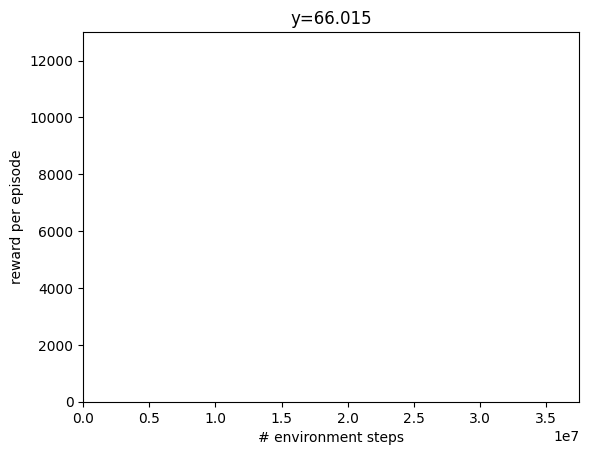

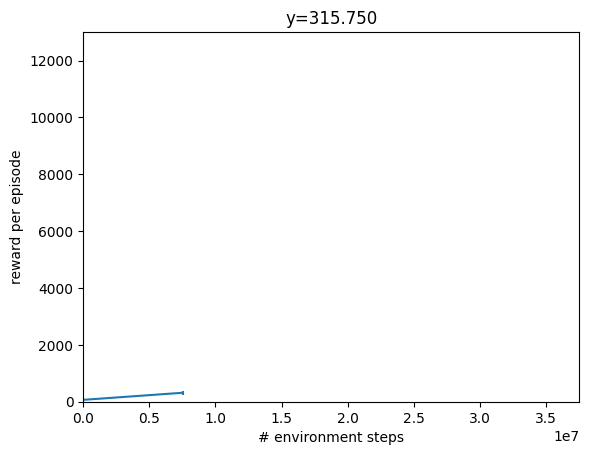

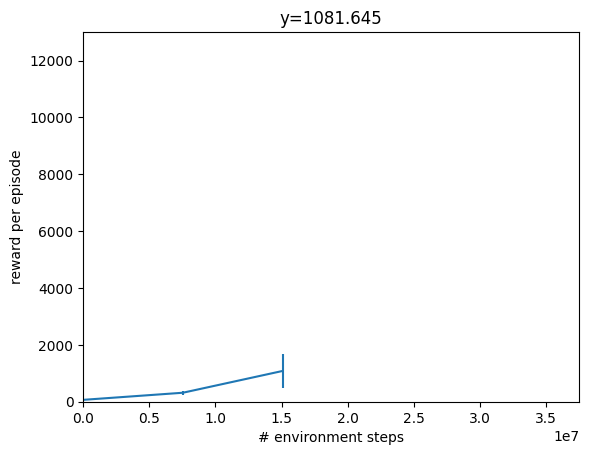

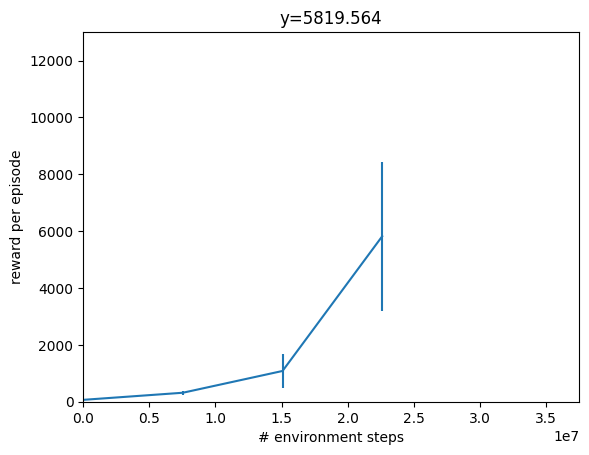

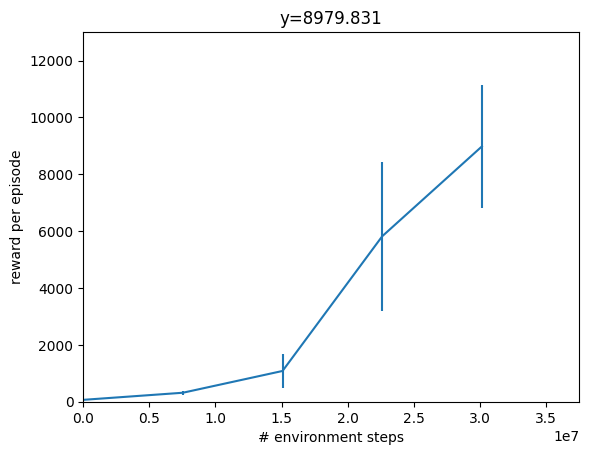

time to jit: 0:00:46.801484
time to train: 0:08:23.749887


In [12]:





train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [13]:
import os

# Create a directory if it does not exist
os.makedirs('model_checkpoints', exist_ok=True)

# Save in the subdirectory
model_path = 'model_checkpoints/model_mjx_policy'
model.save_params(model_path, params)

In [15]:
#@title Load Model and Define Inference Function
model_path = 'model_checkpoints/model_mjx_policy'
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [16]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

#media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)

In [2]:
#media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)


HTML(html.render(env.sys.replace(dt=env.dt), rollout))

NameError: name 'HTML' is not defined